In [1]:
class Config:
    def __init__(self):
        pass

def set_config(config_dict):
    config = Config()
    config.__dict__ = config_dict
    return config

import math
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime, timedelta

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import adam_v2
from keras.callbacks import Callback
from keras import backend as K

%matplotlib inline

columns_train = ['tavg', 'rh_avg', 'rr', 'ff_avg']

config = set_config({
    "input_size": columns_train.__len__(),
    "seq_len": 14,
    "batch_size": 256,
    "output_size": 1,
    "hidden_size": 64,
    # "num_layers": 2,
    "dropout": 0.1,
    "bidirectional": True,
    "learning_rate": 0.01,
    "max_epochs": 2,
    "time_col": 'tanggal',
    "prediction_col": columns_train[2],
    'much_day_predict': 10 + 1,
    'validation_split': 0.1,
    'suffle': False,
    'nan_handling': 1,
})

usecols = [config.time_col] + columns_train

def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true)))

def printProgressBar(iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

In [2]:
dataset_train = pd.read_csv('../Assets/Data/1985-2021.csv', usecols=usecols).replace(to_replace=[8888, 9999, 2555], value=np.nan)

if config.nan_handling == 1:
  dataset_train.dropna(inplace=True)
elif config.nan_handling == 2:
  dataset_train.interpolate(inplace=True)

datelist_train = list(dataset_train[config.time_col])
datelist_train = [datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

dataset_train = dataset_train[columns_train]
training_set = dataset_train.values

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(columns_train))
print('Shape of training set == {}.'.format(training_set.shape))

scaller = MinMaxScaler()
training_set_scaled = scaller.fit_transform(training_set)

sc_predict = MinMaxScaler()
sc_predict.fit_transform(training_set[:, 2:3])

X_train = []
y_train = []

n_future = config.much_day_predict   # Number of days we want top predict into the future
n_past = config.seq_len     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 2])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

Training set shape == (8848, 4)
All timestamps == 8848
Featured selected: ['tavg', 'rh_avg', 'rr', 'ff_avg']
Shape of training set == (8848, 4).
X_train shape == (8824, 14, 3).
y_train shape == (8824, 1).


In [109]:
model = Sequential()

model.add(LSTM(units=config.hidden_size, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))
model.add(LSTM(units=config.hidden_size, return_sequences=False))
model.add(Dropout(config.dropout))
model.add(Dense(units=config.output_size, activation='linear'))

model.compile(optimizer = adam_v2.Adam(learning_rate=config.learning_rate), loss=root_mean_squared_error)

batch_train_length = math.floor((y_train.__len__()*(1-config.validation_split))/config.batch_size)
batch_test_length = math.floor((y_train.__len__()*config.validation_split)/config.batch_size)

class CustomCallback(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print("\nStart Epoch {}/{}".format(epoch + 1, config.max_epochs))

    def on_epoch_end(self, epoch, logs=None):
        print("End Epoch {}/{} of training - loss: {} - val_loss: {} - lr: {}".format(epoch + 1, config.max_epochs,
              round(logs['loss'], 5), round(logs['val_loss'], 5), round(logs['lr'], 5)))

    def on_train_begin(self, logs=None):
        print("Starting Training with Tensor Dimension (N, S, F) : ({} , {} , {})".format(
            batch_train_length, config.seq_len, dataset_train.shape[1]))

    def on_train_end(self, logs=None):
        print("Stop Training - loss: {} - val_loss: {}".format(
            round(logs['loss'], 5), round(logs['val_loss'], 5)))

    def on_train_batch_end(self, batch, logs=None):
        printProgressBar(batch, batch_train_length, prefix='Training Batch ' + str(batch) + "/" + str(
            batch_train_length), suffix='Complete - loss : ' + str(round(logs['loss'], 5)), length=batch_train_length)

    def on_test_batch_end(self, batch, logs=None):
        printProgressBar(batch, batch_test_length, prefix='Evaluating of Batch ' + str(batch) + "/" + str(
            batch_test_length), suffix='Complete - loss : ' + str(round(logs['loss'], 5)), length=batch_test_length)

es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
# mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
# tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=config.suffle, epochs=config.max_epochs, callbacks=[es, rlr, CustomCallback()], validation_split=config.validation_split, verbose=0, batch_size=config.batch_size)

Starting Training with Tensor Dimension (N, S, F) : (45 , 14 , 4)

Start Epoch 1/2
Training Batch 45/45 |█████████████████████████████████████████████| 100.0% Complete - loss : 0.10053
Evaluating of Batch 5/5 |█████| 100.0% Complete - loss : 0.06984
End Epoch 1/2 of training - loss: 0.10053 - val_loss: 0.06984 - lr: 0.009999999776482582

Start Epoch 2/2
Training Batch 45/45 |█████████████████████████████████████████████| 100.0% Complete - loss : 0.07625
Evaluating of Batch 5/5 |█████| 100.0% Complete - loss : 0.06756
End Epoch 2/2 of training - loss: 0.07625 - val_loss: 0.06756 - lr: 0.009999999776482582
dict_keys(['loss', 'val_loss'])
Stop Training - loss: 0.07625 - val_loss: 0.06756


In [7]:
predictions_train = model.predict(X_train[n_past:], verbose=1)
predictions_future = model.predict(X_train[-n_future:], verbose=1)

1/1 [==============================] - 0s 39ms/step


In [106]:
START_DATE_FOR_PLOTTING = (
    datelist_train[-1] - timedelta(days=180)).strftime("%Y-%m-%d")

datelist_future = pd.date_range(
    datelist_train[-1], periods=n_future, freq='1d')

y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=[
                                  config.prediction_col]).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=[config.prediction_col]).set_index(
    pd.Series(datelist_train[2 * n_past + n_future - 1:]))
DATASET_TRAIN = pd.DataFrame(dataset_train, columns=columns_train).set_index(
    pd.Series(datelist_train))

PREDICTIONS_FUTURE.index = PREDICTIONS_FUTURE.index.to_series().apply(
    lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(
    lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
DATASET_TRAIN.index = DATASET_TRAIN.index.to_series().apply(
    lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))

jsonFile = open("dataFrame.json", "w")
jsonFile.write(json.dumps({
    'future': pd.DataFrame({
        "tanggal": [x.strftime('%d-%m-%Y') for x in PREDICTIONS_FUTURE.index],
        config.prediction_col: [
            x for x in PREDICTIONS_FUTURE[config.prediction_col]]
    }).to_dict('records'),
    'train': pd.DataFrame({
        "tanggal": [x.strftime('%d-%m-%Y') for x in PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index],
        config.prediction_col: PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:][config.prediction_col].tolist()
    }).to_dict('records'),
    'histori': pd.DataFrame({
        "tanggal": [x.strftime('%d-%m-%Y') for x in DATASET_TRAIN.loc[START_DATE_FOR_PLOTTING:].index],
        config.prediction_col: DATASET_TRAIN.loc[START_DATE_FOR_PLOTTING:][config.prediction_col].tolist()
    }).to_dict('records'),
}))
jsonFile.close()

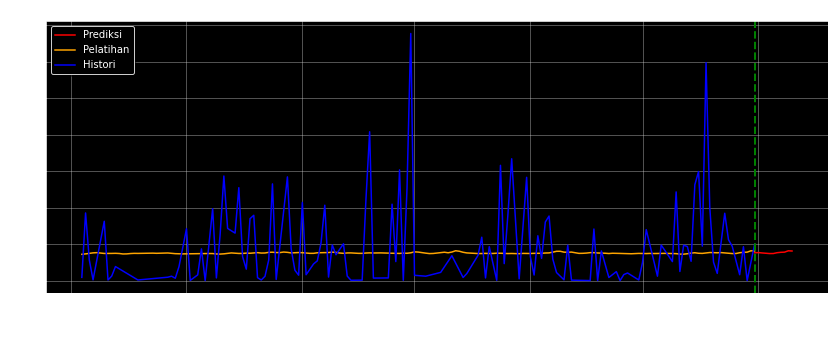

In [36]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE[config.prediction_col], color='r', label='Prediksi')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:][config.prediction_col], color='orange', label='Pelatihan')
plt.plot(DATASET_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, DATASET_TRAIN.loc[START_DATE_FOR_PLOTTING:][config.prediction_col], color='b', label='Histori')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Prediksi dan Histori Curah Hujan', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Tingkat Curah Hujan', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()